In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.callbacks import ModelCheckpoint,Callback
from tensorflow.keras import Model
from tensorflow.keras import optimizers
import numpy as np
import keras
from skimage import io
from keras.utils import np_utils
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
tf.debugging.set_log_device_placement(True)

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


# Loading the Testing Dataset(DDFF Dataset)

In [5]:
test_dir = 'final_dataset/ddff/'
datagen = ImageDataGenerator(rescale=1./255)

test_gen = datagen.flow_from_directory(directory=test_dir, target_size=(224,224), 
                                            class_mode='binary',batch_size=10, shuffle=False)

Found 6000 images belonging to 2 classes.


In [6]:
test_gen.classes

array([0, 0, 0, ..., 1, 1, 1])

In [7]:
real_img = os.listdir(test_dir+'real')
len(real_img)

1200

In [8]:
fake_img = os.listdir(test_dir+'fake')
len(fake_img)

4800

In [9]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

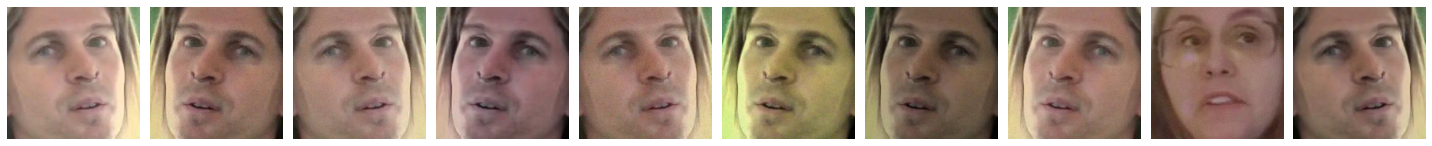

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [10]:
imgs, labels = next(test_gen)
plotImages(imgs)
print(labels)

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Loading all the Models

In [12]:
#VGG16 Final Model
vgg16 = tf.keras.models.load_model('VGG_s_models/model_2/')

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op As

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:loca

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RestoreV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RestoreV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RestoreV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:lo

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerC

In [13]:
#InceptionNet Final Model
InceptionNet = tf.keras.models.load_model('Inception_v3_models/train_2/')

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:local

Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:G

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task

Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/rep

Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/re

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/dev

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localh

Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/rep

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localh

Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/rep

Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localh

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/rep

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task

Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localh

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localh

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RestoreV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RestoreV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RestoreV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RestoreV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device 

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariabl

In [14]:
#EffcientNet Final Model
EffcientNet = tf.keras.models.load_model('EffiecientNetB0_models/EffNet_final.h5')

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:l

Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/repl

Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localh

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/repl

Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost

Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localh

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:lo

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:l

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:l

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:l

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:l

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:l

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:l

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:l

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:l

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:l

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:loc

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:loc

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

# Setting a Decision Threshold

In [16]:
def DT(arr):
    prediction_list_1 = []
    decision_threshold = 0.6
    for list in arr:
        for number in list:
            if(np.round(number,1) < decision_threshold):
                prediction_list_1.append(0)
                
            else:
                prediction_list_1.append(1)
    re_list = np.array(prediction_list_1).reshape(-1,1)
    return re_list    

# Testing VGG16 Model

In [17]:
vgg16_predictions = vgg16.predict(test_gen, steps=len(test_gen), verbose = 1)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeI

 51/600 [=>............................] - ETA: 36sExecuting op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
 68/600 [==>...........................] - ETA: 35sExecuting op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
 83/600 [===>..........................] - ETA: 35sExecuting op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
 94/600 [===>..........................] - ETA: 34sExecuting op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/re

109/600 [====>.........................] - ETA: 33sExecuting op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
112/600 [====>.........................] - ETA: 32sExecuting op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
144/600 [======>.......................] - ETA: 31sExecuting op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
154/600 [======>.......................] - ETA: 30sExecuting op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/re

159/600 [======>.......................] - ETA: 29sExecuting op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
163/600 [=======>......................] - ETA: 29sExecuting op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
166/600 [=======>......................] - ETA: 29sExecuting op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
173/600 [=======>......................] - ETA: 28sExecuting op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/re

232/600 [==========>...................] - ETA: 27sExecuting op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
246/600 [===========>..................] - ETA: 26sExecuting op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
257/600 [===========>..................] - ETA: 25sExecuting op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
264/600 [============>.................] - ETA: 24sExecuting op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/re

298/600 [=============>................] - ETA: 21sExecuting op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
300/600 [==============>...............] - ETA: 21sExecuting op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
304/600 [==============>...............] - ETA: 21sExecuting op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
307/600 [==============>...............] - ETA: 21sExecuting op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/re

415/600 [===================>..........] - ETA: 13sExecuting op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
427/600 [====================>.........] - ETA: 12sExecuting op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0


479/600 [======================>.......] - ETA: 8sExecuting op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
481/600 [=======================>......] - ETA: 8sExecuting op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0


485/600 [=======================>......] - ETA: 8sExecuting op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
493/600 [=======================>......] - ETA: 7sExecuting op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
499/600 [=======================>......] - ETA: 7sExecuting op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
504/600 [========================>.....] - ETA: 6sExecuting op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replic

548/600 [==========================>...] - ETA: 3sExecuting op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
555/600 [==========================>...] - ETA: 3sExecuting op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
559/600 [==========================>...] - ETA: 2sExecuting op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
569/600 [===========================>..] - ETA: 2sExecuting op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replic

600/600 [==============================] - 49s 70ms/step
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ConcatV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0


# Testing InceptionNet_V3 Model

In [18]:
InceptionNet_predictions = InceptionNet.predict(test_gen, steps=len(test_gen), verbose = 1)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Anon

 55/600 [=>............................] - ETA: 15sExecuting op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
 57/600 [=>............................] - ETA: 15sExecuting op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
 59/600 [=>............................] - ETA: 15sExecuting op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
 61/600 [==>...........................] - ETA: 15sExecuting op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/re

119/600 [====>.........................] - ETA: 13sExecuting op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
121/600 [=====>........................] - ETA: 13sExecuting op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
123/600 [=====>........................] - ETA: 13sExecuting op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
125/600 [=====>........................] - ETA: 13sExecuting op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/re

183/600 [========>.....................] - ETA: 11sExecuting op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
185/600 [========>.....................] - ETA: 11sExecuting op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
187/600 [========>.....................] - ETA: 11sExecuting op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
189/600 [========>.....................] - ETA: 11sExecuting op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/re

247/600 [===========>..................] - ETA: 9s Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
249/600 [===========>..................] - ETA: 9sExecuting op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
251/600 [===========>..................] - ETA: 9sExecuting op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
253/600 [===========>..................] - ETA: 9sExecuting op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/repli

311/600 [==============>...............] - ETA: 8sExecuting op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
313/600 [==============>...............] - ETA: 8sExecuting op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
315/600 [==============>...............] - ETA: 8sExecuting op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
317/600 [==============>...............] - ETA: 7sExecuting op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replic

439/600 [====================>.........] - ETA: 4sExecuting op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
441/600 [=====================>........] - ETA: 4sExecuting op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
443/600 [=====================>........] - ETA: 4sExecuting op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
445/600 [=====================>........] - ETA: 4sExecuting op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replic

504/600 [========================>.....] - ETA: 2sExecuting op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
506/600 [========================>.....] - ETA: 2sExecuting op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
508/600 [========================>.....] - ETA: 2sExecuting op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
510/600 [========================>.....] - ETA: 2sExecuting op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replic

# Testing EffcientNetB0 Model

In [19]:
EffcientNet_predictions = EffcientNet.predict(test_gen, steps=len(test_gen), verbose = 1)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Anon

 58/600 [=>............................] - ETA: 12sExecuting op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
 61/600 [==>...........................] - ETA: 12sExecuting op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
 64/600 [==>...........................] - ETA: 12sExecuting op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inferenc

127/600 [=====>........................] - ETA: 10sExecuting op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
130/600 [=====>........................] - ETA: 10sExecuting op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
133/600 [=====>........................] - ETA: 10sExecuting op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inferenc

196/600 [========>.....................] - ETA: 8sExecuting op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
198/600 [========>.....................] - ETA: 8sExecuting op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
201/600 [=========>....................] - ETA: 8sExecuting op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
204/600 [=========>.......

Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
266/600 [============>.................] - ETA: 7sExecuting op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
269/600 [============>.................] - ETA: 7sExecuting op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
272/600 [============>.................] - ETA: 7sExecuting op __inference_p

Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
334/600 [===============>..............] - ETA: 5sExecuting op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
337/600 [===============>..............] - ETA: 5sExecuting op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
340/600 [================>.............] - ETA: 5sExecuting op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_p

402/600 [===================>..........] - ETA: 4sExecuting op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
405/600 [===================>..........] - ETA: 4sExecuting op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
408/600 [===================>..........] - ETA: 4sExecuting op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_p

Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
539/600 [=========================>....] - ETA: 1sExecuting op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
542/600 [==========================>...] - ETA: 1sExecuting op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
545/600 [==========================>...] - ETA: 1sExecuting op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_p

# Visualization of all the Models First Train

In [20]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.callbacks import ModelCheckpoint,Callback
from sklearn import metrics
from tensorflow.keras.models import load_model

# VGG-16 Model Visualization

In [21]:
base_score_test = metrics.accuracy_score(test_gen.classes, DT(vgg16_predictions))
print('VGG Model Test Score ',base_score_test)

VGG Model Test Score  0.6988333333333333


In [22]:
roc_auc_score(test_gen.classes, DT(vgg16_predictions))

0.5623958333333333

In [23]:
base_report_VGG = classification_report(test_gen.classes,DT(vgg16_predictions))
print(base_report_VGG)

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      4800
           1       0.28      0.34      0.31      1200

    accuracy                           0.70      6000
   macro avg       0.56      0.56      0.56      6000
weighted avg       0.72      0.70      0.71      6000



In [24]:
 yhat = DT(vgg16_predictions)
cm = confusion_matrix(y_true=test_gen.classes, y_pred=yhat)

Confusion matrix, without normalization
[[3791 1009]
 [ 798  402]]


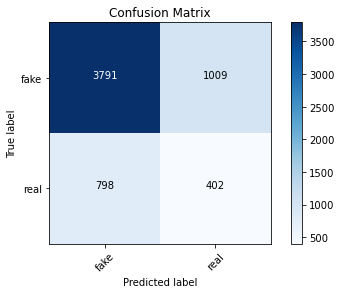

In [25]:
cm_plot_labels = ['fake','real']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# Inception Model Visualization

In [26]:
base_score_test_IN = metrics.accuracy_score(test_gen.classes,DT(InceptionNet_predictions))
print('Inception Model Test Score ',base_score_test_IN)

Inception Model Test Score  0.7338333333333333


In [27]:
roc_auc_score(test_gen.classes, DT(InceptionNet_predictions))

0.5733333333333334

In [28]:
base_report_IN = classification_report(test_gen.classes,DT(InceptionNet_predictions))
print(base_report_IN)

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      4800
           1       0.32      0.31      0.31      1200

    accuracy                           0.73      6000
   macro avg       0.58      0.57      0.57      6000
weighted avg       0.73      0.73      0.73      6000



In [29]:
 yhat = DT(InceptionNet_predictions)
cm = confusion_matrix(y_true=test_gen.classes, y_pred=yhat)

Confusion matrix, without normalization
[[4036  764]
 [ 833  367]]


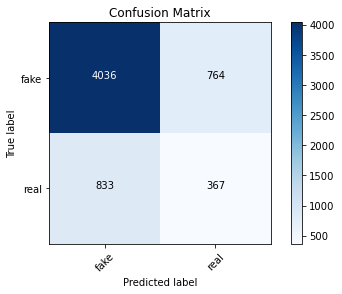

In [30]:
cm_plot_labels = ['fake','real']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# EffcientNetB0 Model Visualization

In [31]:
base_score_test_EN = metrics.accuracy_score(test_gen.classes,DT(EffcientNet_predictions))
print('EffcientNetB0 Model Test Score ',base_score_test_EN)

EffcientNetB0 Model Test Score  0.7155


In [32]:
roc_auc_score(test_gen.classes, DT(EffcientNet_predictions))

0.574375

In [33]:
base_report_EN = classification_report(test_gen.classes,DT(EffcientNet_predictions))
print(base_report_EN)

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      4800
           1       0.31      0.34      0.32      1200

    accuracy                           0.72      6000
   macro avg       0.57      0.57      0.57      6000
weighted avg       0.73      0.72      0.72      6000



In [36]:
 yhat = DT(EffcientNet_predictions)
cm = confusion_matrix(y_true=test_gen.classes, y_pred=yhat)

Confusion matrix, without normalization
[[3886  914]
 [ 793  407]]


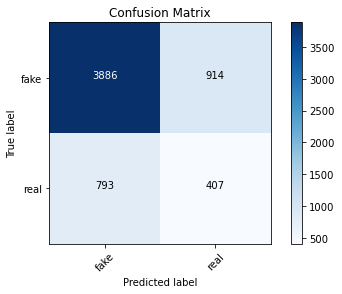

In [37]:
cm_plot_labels = ['fake','real']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# Stacking and Testing with DDFF

In [40]:
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from keras.callbacks import EarlyStopping
from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,Dropout
from numpy import dstack
from sklearn.linear_model import LogisticRegression

In [41]:
members = [vgg16, InceptionNet, EffcientNet]

In [42]:
# create stacked model input dataset as outputs from the ensemble
def stacked_data(members, inputX):
    stackX = None
    for model in members:
        # make prediction
        yhat_1 = model.predict(inputX, verbose=0)
        yhat = DT(yhat_1)
        # stack predictions into [rows, members, probabilities]
        if stackX is None:
            stackX = yhat
        else:
            stackX = dstack((stackX, yhat))
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

In [43]:
# fit a model based on the outputs from the ensemble members
from sklearn.svm import SVC
def fit_stacked_model(members, inputX, inputy):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # fit standalone model
    model = SVC(kernel='sigmoid')#meta learner
    model.fit(stackedX, inputy)
    return model

In [44]:
model = fit_stacked_model(members, test_gen,test_gen.classes)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executin

Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/

Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/

Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/

Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/

Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/

Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/

Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/

Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/

Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/

Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/

Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/

Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/

Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/

Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/

Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/

Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/

Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/

Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/

Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/

Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/

Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/

Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/

In [45]:
# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # make a prediction
    yhat = model.predict(stackedX)
    return yhat

In [46]:
yhat = stacked_prediction(members, model, test_gen)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executin

Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/

Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/

Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/

Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/

Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/

Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/

Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_57771 in device /job:localhost/

Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/

Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/

Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/

Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/

Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/

Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/

Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/

Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_60081 in device /job:localhost/

Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/

Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/

Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/

Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/

Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/

Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/

Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_62364 in device /job:localhost/

In [47]:
base_score_test = metrics.accuracy_score(test_gen.classes,yhat )
print('Stacking Model Test Score ',np.round(base_score_test,3)*100)

Stacking Model Test Score  76.7


In [48]:
roc_auc_score(test_gen.classes, yhat)


0.5476041666666667

In [49]:
base_report_EN = classification_report(test_gen.classes,yhat)
print(base_report_EN)

              precision    recall  f1-score   support

           0       0.82      0.91      0.86      4800
           1       0.34      0.18      0.24      1200

    accuracy                           0.77      6000
   macro avg       0.58      0.55      0.55      6000
weighted avg       0.72      0.77      0.74      6000



In [50]:
cm = confusion_matrix(y_true=test_gen.classes, y_pred=yhat)

Confusion matrix, without normalization
[[4385  415]
 [ 982  218]]


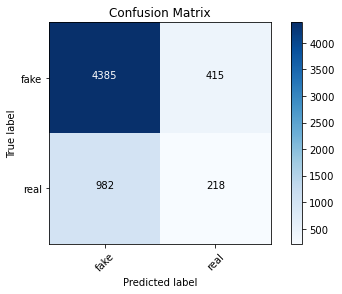

In [51]:
cm_plot_labels = ['fake','real']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')